In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
from pathlib import Path
from copy import deepcopy
from typing import Tuple, List, Callable

import numpy as np
import pandas as pd
import glob
from datetime import datetime, timedelta
from pyproj import Geod
from tqdm import tqdm
import matplotlib.pyplot as plt
import random


import folium
import folium.plugins

In [3]:
wgs84_geod = Geod(ellps='WGS84') # Distance will be measured in meters on this ellipsoid - more accurate than a spherical method
def distance(lat1,lon1,lat2,lon2):
    _,_,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2) # Yes, this order is correct
    return dist

def coords_to_areas(target: pd.Series) -> pd.Series: # Calculate to which area an opening's coordinates (target) "belong to"
    # Following 3 lines needed to have a Series of the same length as area_centers with target as value
    dist = deepcopy(area_grid) # Without deepcopy area_centers is modified in the next 2 lines
    dist['TGPS_Latitude'] = target['GPS_Latitude']
    dist['TGPS_Longitude'] = target['GPS_Longitude']
    
    dist = distance(dist['GPS_Latitude'], dist['GPS_Longitude'], dist['TGPS_Latitude'], dist['TGPS_Longitude'])
    return pd.Series(1 - dist / sum(dist)) # Percentage of how much an opening belongs to each area

In [4]:
rental = pd.read_csv(Path.cwd().parent / 'data' / 'processed' / 'rental.csv', low_memory=False)
openings = pd.read_csv(Path.cwd().parent / 'data' / 'processed' / 'openings.csv')
virtual_area_centers = pd.read_csv(Path.cwd().parent / 'data' / 'processed' / 'areas.csv', index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\ad200800\\OneDrive - Arriva\\mlprojekt\\data\\processed\\rental.csv'

In [ ]:
# Area centers based on current areas
area_centers = rental.groupby('Start_Zone_Name').mean()[['Start_GPS_Latitude','Start_GPS_Longitude']]
area_centers.rename(columns={
    'Start_GPS_Latitude': 'GPS_Latitude', 
    'Start_GPS_Longitude': 'GPS_Longitude'}, inplace=True)
area_centers.index.names = ['Area']

In [ ]:
rental['Start_Datetime_Local'] = pd.to_datetime(rental['Start_Datetime_Local'], format='%Y-%m-%d %H:%M')
rental['End_Datetime_Local'] = pd.to_datetime(rental['End_Datetime_Local'], format='%Y-%m-%d %H:%M')
rental = pd.get_dummies(rental, columns=['Vehicle_Engine_Type'], drop_first=True)
rental = pd.get_dummies(rental, columns=['Vehicle_Model'])

In [ ]:
openings['Created_Datetime_Local'] = pd.to_datetime(openings['Created_Datetime_Local'], format='%Y-%m-%d %H:%M')
openings = pd.get_dummies(openings, columns=['Platform'], drop_first=True)

In [ ]:
time_start = max(rental['Start_Datetime_Local'].min(), openings['Created_Datetime_Local'].min())
time_end = min(rental['End_Datetime_Local'].max(), openings['Created_Datetime_Local'].max())
print('Time limits:', time_start, 'to', time_end)
total_time = time_end-time_start

In [ ]:
ratio = []
for _ in tqdm(range(1000)):
    timepoint = time_start + timedelta(seconds=total_time.total_seconds()*random.uniform(0,1))
    #filtered_rentals = rental[rental['End_Datetime_Local'] <= timepoint].drop('Revenue_Net', axis=1)
    #filtered_rentals = filtered_rentals.sort_values(by='End_Datetime_Local').drop_duplicates(subset='Vehicle_Number_Plate', keep='last') # Keep the last location
    current_trips = rental[(rental['Start_Datetime_Local'] <= timepoint) & (rental['End_Datetime_Local'] > timepoint) & (rental['Servicedrive_YN']==1)] # Cars in use
    ratio.append(len(current_trips))

bins = np.arange(0, 10, 1) # fixed bin size
plt.xlim([0, 10])
plt.hist(ratio, bins=bins, density=True)
plt.title('Histogram of cars being relocated at random times')
plt.xlabel('Cars being relocated')
plt.ylabel('Count')

plt.show()

In [ ]:
ratio = []
for _ in tqdm(range(1000)):
    timepoint = time_start + timedelta(seconds=total_time.total_seconds()*random.uniform(0,1))
    #filtered_rentals = rental[rental['End_Datetime_Local'] <= timepoint].drop('Revenue_Net', axis=1)
    #filtered_rentals = filtered_rentals.sort_values(by='End_Datetime_Local').drop_duplicates(subset='Vehicle_Number_Plate', keep='last') # Keep the last location
    current_trips = rental[(rental['Start_Datetime_Local'] <= timepoint) & (rental['End_Datetime_Local'] > timepoint) & (rental['Servicedrive_YN']==0)] # Cars in use
    ratio.append(len(current_trips))

bins = np.arange(0, 200, 1) # fixed bin size
plt.xlim([0, 200])
plt.hist(ratio, bins=bins, density=True)
plt.title('Histogram of cars in random times')
plt.xlabel('Cars in use')
plt.ylabel('Count')

plt.show()

In [ ]:
rental['After_reloc'] = rental.groupby('Vehicle_Number_Plate')['Servicedrive_YN'].shift()

In [ ]:
plt.hist(rental[(rental['Servicedrive_YN']==0) & (rental['Revenue_Net']!=0)]['Revenue_Net'], bins=range(0,200,10), density=True, alpha=0.5, label='All revenues')
plt.hist(rental[(rental['Servicedrive_YN']==0) & (rental['Revenue_Net']!=0) & (rental['After_reloc']==1)]['Revenue_Net'], bins=range(0,200,10), density=True, alpha=0.5, label='Revenues after relocation')
plt.hist(rental[(rental['Servicedrive_YN']==0) & (rental['Revenue_Net']!=0) & (rental['After_reloc']==0)]['Revenue_Net'], bins=range(0,200,10), density=True, alpha=0.5, label='Revenues without relocation')
plt.legend()
plt.show()
print('Mean total:', '{:2.2f}'.format(rental[(rental['Servicedrive_YN']==0) & (rental['Revenue_Net']!=0)]['Revenue_Net'].mean()))
print('Mean after relocation:', '{:2.2f}'.format(rental[(rental['Servicedrive_YN']==0) & (rental['Revenue_Net']!=0) & (rental['After_reloc']==1)]['Revenue_Net'].mean()))
print('Mean without relocation:', '{:2.2f}'.format(rental[(rental['Servicedrive_YN']==0) & (rental['Revenue_Net']!=0) & (rental['After_reloc']==0)]['Revenue_Net'].mean()))
print('Increase:', '{:2.2%}'.format(rental[(rental['Servicedrive_YN']==0) & (rental['Revenue_Net']!=0) & (rental['After_reloc']==1)]['Revenue_Net'].mean()/rental[(rental['Servicedrive_YN']==0) & (rental['Revenue_Net']!=0)]['Revenue_Net'].mean()-1))

In [ ]:
print('Percentage of rentals per zone')
rental.groupby('Start_Zone_Name')['Vehicle_Number_Plate'].count().sort_values(ascending=False)/len(rental)

In [ ]:
print('Percentage of rentals per zone')
rental.groupby('Virtual_Start_Zone_Name')['Vehicle_Number_Plate'].count().sort_values(ascending=False)/len(rental)

In [ ]:
plt.bar(x=range(len(virtual_area_centers)), height=rental.groupby('Virtual_Start_Zone_Name')['Vehicle_Number_Plate'].count().sort_values(ascending=False).values/len(rental), alpha=0.7, label='Virtual', width=1)
plt.bar(x=range(len(area_centers)), height=rental.groupby('Start_Zone_Name')['Vehicle_Number_Plate'].count().sort_values(ascending=False).values/len(rental), alpha=0.7, label='Original', width=1)
plt.yscale('log')
plt.legend()
plt.show()

878


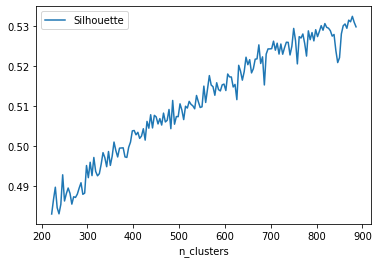

In [25]:
silhouette = pd.read_csv(Path.cwd().parent / 'reports' / 'virtual_area_opt.csv', index_col='0')
silhouette.columns = ['Silhouette']
silhouette.index.names = ['n_clusters']
silhouette.plot()
print(silhouette.iloc[np.argmax(silhouette)].name)

In [ ]:
print('Distribution of rentals unassigned to areas')
start_map_heat = folium.Map([55.6785706133019, 12.594427257404426], zoom_start=12, tiles='Stamen Toner')
folium.plugins.HeatMap(rental[rental['Start_Zone_Name']=='-'].loc[:,['Start_GPS_Latitude', 'Start_GPS_Longitude']], name=None, min_opacity=0.5, max_zoom=18, radius=10,
blur=8, gradient=None, overlay=True, control=True, show=True).add_to(start_map_heat)
display(start_map_heat)

In [ ]:
print('Areas vs. virtual areas')
start_map = folium.Map([55.6785706133019, 12.594427257404426], zoom_start=12, tiles='Stamen Toner')
for name, row in area_centers.iterrows():
    folium.CircleMarker(
        radius=5,
        location=[row['GPS_Latitude'], row['GPS_Longitude']],
        color="crimson",
        tooltip=name,
        fill=False,
    ).add_to(start_map)
for name, row in virtual_area_centers.iterrows():
    folium.CircleMarker(
        radius=5,
        location=[row['GPS_Latitude'], row['GPS_Longitude']],
        color="blue",
        tooltip=name, 
        fill=True
    ).add_to(start_map)
display(start_map)

In [ ]:
def plot_rent_locs(i, fmap, quatity:int=100, colour='crimson'):
    area = virtual_area_centers.index[i]
    rent_locs = rental[rental['Virtual_Start_Zone_Name']==area].loc[:,['Start_GPS_Latitude', 'Start_GPS_Longitude']].iloc[:quatity]
    for _, row in rent_locs.iterrows():
        folium.Circle(
            radius=10,
            location=[row['Start_GPS_Latitude'], row['Start_GPS_Longitude']],
            color=colour,
            fill=False,
        ).add_to(start_map)

In [ ]:
start_map = folium.Map([55.6785706133019, 12.594427257404426], zoom_start=12, tiles='Stamen Toner')

plot_rent_locs(186, start_map, colour='red')
plot_rent_locs(310, start_map, colour='green')
plot_rent_locs(59, start_map, colour='yellow')
plot_rent_locs(227, start_map, colour='purple')

for idx, row in virtual_area_centers.iterrows():
    folium.CircleMarker(
        location=[row['GPS_Latitude'], row['GPS_Longitude']],
        color="blue",
        tooltip=idx, 
        fill=True
    ).add_to(start_map)

display(start_map)

In [ ]:
def actions(timepoint:datetime, window:timedelta=timedelta(hours=1)):
        a = rental[(rental['Servicedrive_YN']==1) &
                        (rental['Start_Datetime_Local'] >= timepoint-window) &
                        (rental['End_Datetime_Local'] < timepoint)]
        all_vehicles = rental.columns[rental.columns.str.contains('Vehicle_Model')] # Get name of vehicles
        a = a[a['Start_Zone_Name'] != a['End_Zone_Name']]
        a = a.loc[:, [*all_vehicles, 'Start_Zone_Name', 'End_Zone_Name', 'Servicedrive_YN']]
        a = pd.melt(a, id_vars=['Start_Zone_Name', 'End_Zone_Name'], value_vars=[*all_vehicles])
        a.rename(columns={'variable': 'Vehicle_Model'}, inplace=True)
        #return a
        return a.groupby(['Vehicle_Model', 'Start_Zone_Name', 'End_Zone_Name']).sum().unstack()

In [ ]:
actions(timepoint=datetime(2020, 6, 12, 12, 0, 0), window=timedelta(hours=2))

In [ ]:
# Function that returns time openings in the last time window at any datetime. Softmax preferred False to get absolute values (an increase in demand everywhere -> softmax is the same)
def demand(timepoint:datetime, window:timedelta=timedelta(hours=1), app_openings:pd.DataFrame=openings, detail:bool=False) -> pd.DataFrame:
    demand_df = deepcopy(app_openings[(app_openings['Created_Datetime_Local'] > timepoint-window) &
                             (app_openings['Created_Datetime_Local'] <= timepoint)])
    demand_df[area_grid.index.values] = 0 # Create columns with area names
    demand_df[area_grid.index.values] = demand_df.apply(coords_to_areas, axis=1) # Apply function to all openings
    if detail:
        return demand_df
    else:
        demand_df = demand_df.sum(axis=0).loc[area_grid.index] # Aggregate demand in the time window over areas (.loc to remove gps coords and platform)se:
        return pd.DataFrame(demand_df, columns=['demand']) # Sum of demand equals to amount of app openings

In [ ]:
# Function that returns the location of all parked vehicles at any datetime. remove_in_use decides to remove vehicles in transit or keep them and pick their last location
def vehicle_locations(timepoint:datetime, rentals:pd.DataFrame=rental, detail:bool=False, remove_in_use:bool=True) -> pd.DataFrame:
    filtered_rentals = rentals[rentals['End_Datetime_Local'] <= timepoint].drop('Revenue_Net', axis=1)
    filtered_rentals = filtered_rentals.sort_values(by='End_Datetime_Local').drop_duplicates(subset='Vehicle_Number_Plate', keep='last') # Keep the last location
    if remove_in_use:
        current_trips = rentals[(rentals['Start_Datetime_Local'] <= timepoint) & (rentals['End_Datetime_Local'] > timepoint)] # Cars in use
        filtered_rentals = filtered_rentals[~filtered_rentals['Vehicle_Number_Plate'].isin(current_trips['Vehicle_Number_Plate'])] # Filter out cars in use
    filtered_rentals = filtered_rentals.loc[:, ~filtered_rentals.columns.str.contains('Start')].drop(columns=['End_Datetime_Local'], axis=1) # Drop unused columns
    filtered_rentals.rename(columns={'End_GPS_Latitude': 'GPS_Latitude', 'End_GPS_Longitude': 'GPS_Longitude', 'End_Zone_Name': 'Zone'}, inplace=True)
    if detail:
        filtered_rentals = pd.get_dummies(filtered_rentals, columns=['Zone'])
        filtered_rentals.columns = filtered_rentals.columns.str.replace('^Zone_', '', regex=True) # Remove area_ prefix in columns
        return filtered_rentals
    else:
        all_vehicles = filtered_rentals.columns[filtered_rentals.columns.str.contains('Vehicle_Model')] # Get name of vehicles
        filtered_rentals = filtered_rentals.groupby('Zone')[all_vehicles].sum() # Aggregate amount of cars
        missing_areas = pd.DataFrame(index=area_centers.index[~area_centers.index.isin(filtered_rentals.index)], columns=filtered_rentals.columns, data=0)
        return pd.concat([filtered_rentals, missing_areas]).sort_index() # Add missing areas, sort and return

In [ ]:
# Function that returns the total revenue in the last time window at any datetime
def revenue(timepoint:datetime, window:timedelta=timedelta(hours=1), rentals:pd.DataFrame=rental) -> float:
    trips_in_window = rentals[(rentals['Start_Datetime_Local'] >= timepoint-window) & (rentals['End_Datetime_Local'] < timepoint)]
    return trips_in_window['Revenue_Net'].sum()

In [ ]:
def get_data(timepoint:datetime, windows:List[timedelta]=[timedelta(hours=1)], coords:bool=False) -> Tuple[Tuple[float], Tuple[pd.DataFrame]]:
    df = deepcopy(area_centers)
    df = pd.concat([df, vehicle_locations(timepoint=timepoint)], axis=1) # Locations now
    dfs = []
    revenues = []
    for time_window in windows:
        locs = vehicle_locations(timepoint=timepoint-time_window, remove_in_use=False) # Locations at beginning of time window
        dem = demand(timepoint=timepoint, window=time_window) # Demand in time window
        locs.columns = locs.columns + '_' + str(int(time_window.days*24 + time_window.seconds/3600)) + 'h' # Add time window to column name
        dem.columns = dem.columns + '_' + str(int(time_window.days*24 + time_window.seconds/3600)) + 'h' # Add time window to column name
        df = pd.concat([df, dem, locs], axis=1) # Add demands and locations to final dataframe
        revenues.append(revenue(timepoint=timepoint, window=time_window))
        if coords:
            dfs.append(df)
        else:
            dfs.append(df.iloc[:,3:])
    return tuple(revenues), tuple(dfs)

In [ ]:
r, df = get_data(timepoint=datetime(2020, 6, 12, 12, 0, 0),
                 windows=[timedelta(hours=1)])

In [ ]:
r[0]

In [ ]:
df[0]